In [1]:
%load_ext autoreload
%autoreload 2

# Activation vs repression

## Imports

In [2]:
import os
import pandas as pd
import re

from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.srv.io.manage.script_manager import script_preamble

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax
import subprocess



## Load data

In [3]:
fn_inter = os.path.join('..', 'data', 'sRNA', 'merged_inter.csv')
fn_merged = os.path.join('..', 'data', 'sRNA', 'merged_EcoCyc_RNAInter_sRNATarBase.csv')
data = pd.read_csv(fn_inter)
merged = pd.read_csv(fn_merged)
try:
    data = data.drop(columns=['Unnamed: 0'])
    merged = merged.drop(columns=['Unnamed: 0'])
except:
    pass


# Binding energy differences 

In [4]:
interaction_data = load_json_as_dict('./data/05_orthogonality_mRNA_official/2023_11_21_095238/inter_data_raw.json')
len(interaction_data)

37

In [5]:
data['Interaction Energy'] = 0.0
for k1 in interaction_data:
    for k2, v in interaction_data[k1].items():
        if k1 in data['Interactor 1'].to_list():
            data.loc[(data['Interactor 1'] == k1) & (data['Interactor 2'] == k2), 'Interaction Energy'] = float(v['E'])
        elif k2 in data['Interactor 1'].to_list():
            data.loc[(data['Interactor 1'] == k2) & (data['Interactor 2'] == k1), 'Interaction Energy'] = float(v['E'])
        else:
            print(k1, k2)
data

        

,Interactor 1,Interactor 2,ID 1,ID 2,Category 1,Category 2,Regulation,Binding position 1,Binding position 2,Sequence 1,Sequence 2,Source DB,Interaction Energy
0,micA,dppA,NCBI:2847697,NCBI:948062,sRNA,mRNA,NaN,NaN,NaN,CAAAAATGGTGTCGCTCGTATTATTGTCGAGAAACCTTTCGGCAAG...,ATGCGTATTTCCTTGAAAAAGTCAGGGATGCTGAAGCTTGGTCTCA...,RNAInter,-16.08
1,dsrA,dsrB,NCBI:946470,NCBI:946468,sRNA,mRNA,NaN,NaN,NaN,AACACATCAGATTTCCTGGTGTAACGAATTTTTTAAGTGCTTCTTG...,TAAATGNAAACAAGTTTTATTTTTATCATCAGAACATTCTAATAAA...,RNAInter,-23.61
2,dsrA,ilvH,NCBI:946470,NCBI:947267,sRNA,mRNA,NaN,NaN,NaN,AACACATCAGATTTCCTGGTGTAACGAATTTTTTAAGTGCTTCTTG...,ATTCGCCACAACAAGGACAGGAAGGTTCGGCGCAAGGAGCCCAAGA...,RNAInter,-13.80
3,micA,ecnB,NCBI:2847697,NCBI:2847737,sRNA,mRNA,NaN,NaN,NaN,CAAAAATGGTGTCGCTCGTATTATTGTCGAGAAACCTTTCGGCAAG...,ATGGTGAAGAAGACAATTGCAGCGATCTTTTCTGTTCTGGTGCTTT...,RNAInter,-11.85
4,oxyS,fhlA,NCBI:2847701,NCBI:947181,sRNA,mRNA,NaN,NaN,NaN,GAAACGGAGCGGCACCTCTTTTAACCCTTGAAGTCACTGCCCGTTT...,CACCAGATTGCCAAGCTGATGGTCGAGCTGTCCAAATCCCAGGATG...,RNAInter,-13.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,ryhB,msrA,"chromosome:NC_000913.3, Gene ID:2847761","chromosome:NC_000913.3, Gene ID:948734",NaN,mRNA,No Interaction,['NA'],['NA'],GCGATCAGGAAGACCCTCGCGGAGAACCTGAAAGCACGACATTGCT...,ATGAGTTTATTTGATAAAAAGCATCTGGTTTCCCCCGCCGATGCCC...,sRNATarBase,-15.83
445,gcvB,hdeA,"chromosome:NC_000913.3, Gene ID:2847720","chromosome:NC_000913.3, Gene ID:948025",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],ACTTCCTGAGCCGGAACGAAAAGTTTTATCGGAATGCGTGTTCTGG...,ATGAAAAAAGTATTAGGCGTTATTCTTGGTGGTCTGCTTCTTCTGC...,sRNATarBase,-12.79
446,gcvB,hdeB,"chromosome:NC_000913.3, Gene ID:2847720","chromosome:NC_000913.3, Gene ID:948026",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],ACTTCCTGAGCCGGAACGAAAAGTTTTATCGGAATGCGTGTTCTGG...,ATGAATATTTCATCTCTCCGTAAAGCGTTTATTTTTATGGGCGCTG...,sRNATarBase,-11.65
447,Esr41,fliC,"chromosome:NC_002695.1, Gene ID:","chromosome:NC_002695.1, Gene ID:",trans-encoded antisense RNA,mRNA,Induction,['NA'],['NA'],GATGCTCTAGGCATCACATTTTCTCCATGGGGTATTCCCTCCGCCG...,ATGGCACAAGTCATTAATACCAACAGCCTCTCGCTGATCACTCAAA...,sRNATarBase,0.00


In [6]:
data['Regulation'] = data['Regulation'].apply(lambda x: x if type(x) == str else 'Unknown')

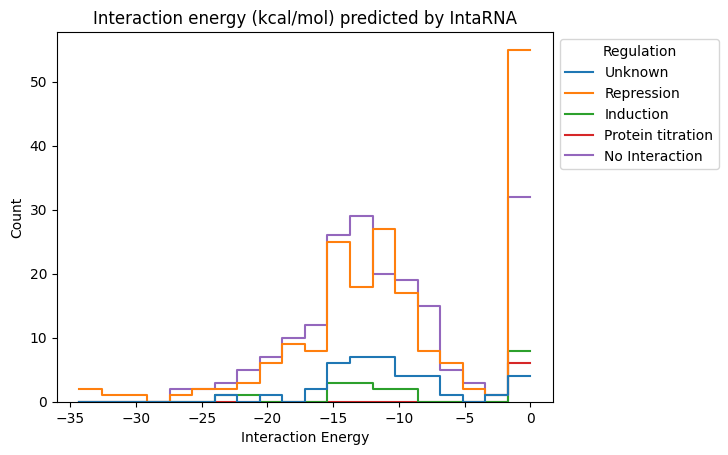

In [7]:
g = sns.histplot(data, x='Interaction Energy', hue='Regulation', element='step', bins=20, fill=False)
plt.title('Interaction energy (kcal/mol) predicted by IntaRNA')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


Text(0.5, 1.0, 'Distal binding by regulation mechanism')

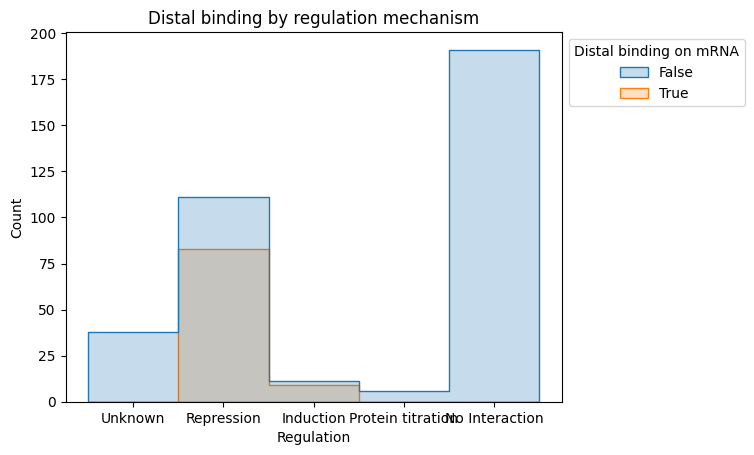

In [21]:
g = sns.histplot(data, x='Regulation', hue=data['Binding position 2'].apply(lambda x: '-' in x if type(x) == str else False), element='step')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.legend_.set_title('Distal binding on mRNA')
plt.title('Distal binding by regulation mechanism')

# Motif differences between activation / repression

# Sequence differences

# Binding site differences

# Protein involvements